# Importing required LIbraries

In [11]:
import cv2
import numpy as np
from skimage.filters import threshold_local
import tensorflow as tf
from skimage import measure
import imutils
import os
import matplotlib.pyplot as plt

In [52]:
def sort_cont(character_contours):
    print("IN sort Contours")
    # To sort contours
    
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in character_contours]
      
    (character_contours, boundingBoxes) = zip(*sorted(zip(character_contours,boundingBoxes),key = lambda b: b[1][i],reverse = False))
      
    return character_contours
  
  
def segment_chars(plate_img, fixed_width):
      
    """
    extract Value channel from the HSV format of image and apply adaptive thresholding
    to reveal the characters on the license plate
    """
    V = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2]
 
    thresh = cv2.adaptiveThreshold(V, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY,
                                   11, 2)
   
    thresh = cv2.bitwise_not(thresh)
    plt.imshow(thresh,cmap="gray")
    plt.show()  
    # resize the license plate region to a canoncial size
    plate_img = imutils.resize(plate_img, width = fixed_width)
    thresh = imutils.resize(thresh, width = fixed_width)
    bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
  
    # perform a connected components analysis
    # and initialize the mask to store the locations of the character candidates
    labels = measure.label(thresh, background = 0)
  
    charCandidates = np.zeros(thresh.shape, dtype ='uint8')
  
    # loop over the unique components
    characters = []
    for label in np.unique(labels):
          
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask to display
        # only connected components for the current label,then find contours in the label mask
        labelMask = np.zeros(thresh.shape, dtype ='uint8')
        labelMask[labels == label] = 255
  
        cnts = cv2.findContours(labelMask,
                     cv2.RETR_EXTERNAL,
                     cv2.CHAIN_APPROX_SIMPLE)
 
        cnts = cnts[1] if imutils.is_cv3() else cnts[0]
  
        # ensure at least one contour was found in the mask
        if len(cnts) > 0:
            
  
            # grab the largest contour which corresponds
            # to the component in the mask, then grab the bounding box for the contour
            c = max(cnts, key = cv2.contourArea)
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)
  
            # compute the aspect ratio, solodity, and height ration for the component
            aspectRatio = boxW / float(boxH)
            solidity = cv2.contourArea(c) / float(boxW * boxH)
            heightRatio = boxH / float(plate_img.shape[0])
  
            # determine if the aspect ratio, solidity,
            # and height of the contour pass the rules
            # tests
            keepAspectRatio = aspectRatio < 1.0
            keepSolidity = solidity > 0.15
            keepHeight = heightRatio > 0.5 and heightRatio < 0.95
            #keepHeight = heightRatio > 0.4 and heightRatio < 0.9
  
            # check to see if the component passes
            # all the tests
            if keepAspectRatio and keepSolidity and keepHeight and boxW > 10:
                print("found Contour")  
                # compute the convex hull of the contour
                # and draw it on the character candidates
                # mask
                hull = cv2.convexHull(c)
  
                cv2.drawContours(charCandidates, [hull], -1, 255, -1)
  
    contours, hier = cv2.findContours(charCandidates,
                                         cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        contours = sort_cont(contours)
          
        # value to be added to each dimension
        # of the character
        addPixel = 4
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            if y > addPixel:
                y = y - addPixel
            else:
                y = 0
            if x > addPixel:
                x = x - addPixel
            else:
                x = 0
            temp = bgr_thresh[y:y + h + (addPixel * 2),
                              x:x + w + (addPixel * 2)]
  
            characters.append(temp)
              
        return characters
      
    else:
        return None

In [92]:
class PlateFinder:
    def __init__(self, minPlateArea, maxPlateArea):
          
        # minimum area of the plate
        self.min_area = minPlateArea
          
        # maximum area of the plate
        self.max_area = maxPlateArea 
  
        self.element_structure = cv2.getStructuringElement(
                              shape = cv2.MORPH_RECT, ksize =(22, 3))
  
    def preprocess(self, input_img):
          
        imgBlurred = cv2.GaussianBlur(input_img, (7, 7), 0)
          
        # convert to gray
        gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)
          
        # sobelX to get the vertical edges
        sobelx = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize = 3) 
          
        # otsu's thresholding
        ret2, threshold_img = cv2.threshold(sobelx, 0, 255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(threshold_img,cmap="gray")
        plt.show()
        element = self.element_structure
        morph_n_thresholded_img = threshold_img.copy()
        cv2.morphologyEx(src = threshold_img,
                         op = cv2.MORPH_CLOSE,
                         kernel = element,
                         dst = morph_n_thresholded_img)
        plt.imshow(morph_n_thresholded_img,cmap="gray")
        plt.show()
        return morph_n_thresholded_img
  
    def extract_contours(self, after_preprocess):
          
        contours, _ = cv2.findContours(after_preprocess,
                                          mode = cv2.RETR_EXTERNAL,
                                          method = cv2.CHAIN_APPROX_NONE)
        #print(contours)
        return contours
  
    def clean_plate(self, plate):
          
        gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       11, 2)
        
          
        contours, _ = cv2.findContours(thresh.copy(),
                                          cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_NONE)
  
        if contours:
            areas = [cv2.contourArea(c) for c in contours]
              
            # index of the largest contour in the area
            # array
            max_index = np.argmax(areas) 
  
            max_cnt = contours[max_index]
            max_cntArea = areas[max_index]
            x, y, w, h = cv2.boundingRect(max_cnt)
            rect = cv2.minAreaRect(max_cnt)
            if not self.ratioCheck(max_cntArea, plate.shape[1],
                                                plate.shape[0]):
                return plate, False, None
            
            print("In contours")
            return plate, True, [x, y, w, h]
          
        else:
            return plate, False, None
  
  
  
    def check_plate(self, input_img, contour):
          
        min_rect = cv2.minAreaRect(contour)
        print(min_rect)  
        if self.validateRatio(min_rect):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = input_img[y:y + h, x:x + w]
            after_clean_plate_img, plateFound, coordinates = self.clean_plate(
                                                        after_validation_img)
            plt.imshow(after_validation_img)
            plt.show()
            if plateFound:
                characters_on_plate = self.find_characters_on_plate(
                                              after_clean_plate_img)
                  
                if (characters_on_plate is not None and len(characters_on_plate) == 10):
                    x1, y1, w1, h1 = coordinates
                    coordinates = x1 + x, y1 + y
                    after_check_plate_img = after_clean_plate_img
                      
                    return after_check_plate_img, characters_on_plate, coordinates
          
        return None, None, None
  
  
  
    def find_possible_plates(self, input_img):
          
        """
        Finding all possible contours that can be plates
        """
        plates = []
        self.char_on_plate = []
        self.corresponding_area = []
  
        self.after_preprocess = self.preprocess(input_img)
        possible_plate_contours = self.extract_contours(self.after_preprocess)
  
        for cnts in possible_plate_contours:
            plate, characters_on_plate, coordinates = self.check_plate(input_img, cnts)
            #print(plate)  
            if plate is not None:
                plates.append(plate)
                self.char_on_plate.append(characters_on_plate)
                self.corresponding_area.append(coordinates)
  
        if (len(plates) > 0):
            return plates
          
        else:
            return None
  
    def find_characters_on_plate(self, plate):
        print("In find characters")
  
        charactersFound = segment_chars(plate, 400)
        if charactersFound:
            print("found Characters")
            return charactersFound
  
    # PLATE FEATURES
    def ratioCheck(self, area, width, height):
        
          
        min = self.min_area
        max = self.max_area
  
        ratioMin = 1.5
        ratioMax = 6
  
        ratio = float(width) / float(height)
          
        if ratio < 1:
            ratio = 1 / ratio
          
        if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
            return False
        print("In Ratio..")  
        return True
  
    def preRatioCheck(self, area, width, height):
        
          
        min = self.min_area
        max = self.max_area
  
        ratioMin = 1.5
        ratioMax = 5
  
        ratio = float(width) / float(height)
          
        if ratio < 1:
            ratio = 1 / ratio
  
        if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
            return False
        print("Passed pre Ratio..")  
        return True
  
    def validateRatio(self, rect):
        
        (x, y), (width, height), rect_angle = rect

  
        if (width > height):
            angle = -rect_angle
        else:
            angle = 90 + rect_angle
  
        if angle > 15:
            return False
          
        if (height == 0 or width == 0):
            return False
  
        area = width * height
          
        if not self.preRatioCheck(area, width, height):
            return False
        else:
            print("In validate Ratio..")
            return True
        
        

In [93]:

        
class OCR:
      
    def __init__(self, modelFile, labelFile):
          
        self.model_file = modelFile
        self.label_file = labelFile
        self.label = self.load_label(self.label_file)
        self.graph = self.load_graph(self.model_file)
        self.sess = tf.compat.v1.Session(graph=self.graph, 
                                         config=tf.compat.v1.ConfigProto())
  
    def load_graph(self, modelFile):
          
        graph = tf.Graph()
        graph_def = tf.compat.v1.GraphDef()
          
        with open(modelFile, "rb") as f:
            graph_def.ParseFromString(f.read())
          
        with graph.as_default():
            tf.import_graph_def(graph_def)
          
        return graph
  
    def load_label(self, labelFile):
        label = []
        proto_as_ascii_lines = tf.io.gfile.GFile(labelFile).readlines()
          
        for l in proto_as_ascii_lines:
            label.append(l.rstrip())
          
        return label
  
    def convert_tensor(self, image, imageSizeOuput):
        """
        takes an image and transform it in tensor
        """
        image = cv2.resize(image,
                           dsize =(imageSizeOuput,
                                  imageSizeOuput),
                           interpolation = cv2.INTER_CUBIC)
          
        np_image_data = np.asarray(image)
        np_image_data = cv2.normalize(np_image_data.astype('float'),
                                      None, -0.5, .5,
                                      cv2.NORM_MINMAX)
          
        np_final = np.expand_dims(np_image_data, axis = 0)
          
        return np_final
  
    def label_image(self, tensor):
  
        input_name = "import/input"
        output_name = "import/final_result"
  
        input_operation = self.graph.get_operation_by_name(input_name)
        output_operation = self.graph.get_operation_by_name(output_name)
  
        results = self.sess.run(output_operation.outputs[0],
                                {input_operation.outputs[0]: tensor})
        results = np.squeeze(results)
        labels = self.label
        top = results.argsort()[-1:][::-1]
          
        return labels[top[0]]
  
    def label_image_list(self, listImages, imageSizeOuput):
        plate = ""
          
        for img in listImages:
              
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            plate = plate + self.label_image(self.convert_tensor(img, imageSizeOuput))
          
        return plate, len(plate)
   

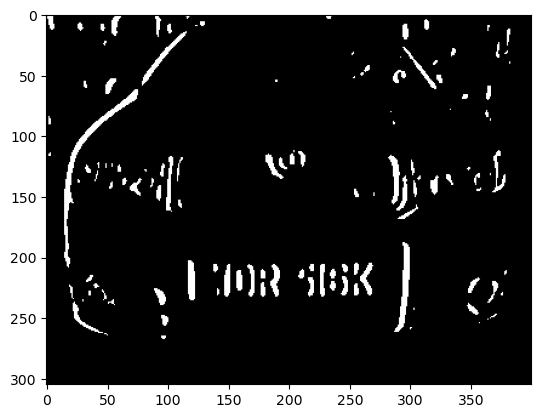

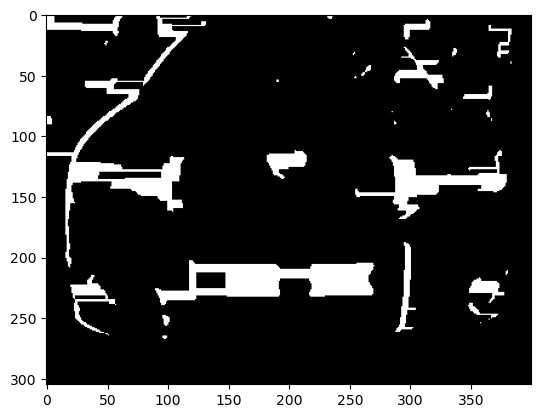

((97.5, 266.0), (2.0, 3.0), 90.0)
((50.100013732910156, 263.3000183105469), (2.2360680103302, 0.4472135603427887), 26.56505012512207)
((358.0, 254.0), (0.0, 0.0), 0.0)
((365.0, 251.0), (0.0, 0.0), 0.0)
((98.5, 252.0), (8.0, 5.0), 90.0)
((359.2759094238281, 245.18966674804688), (24.81691551208496, 6.696628570556641), 23.198591232299805)
Passed pre Ratio..
In validate Ratio..


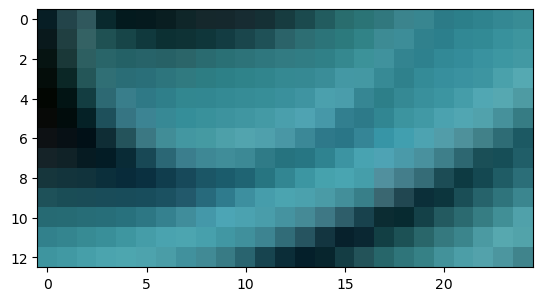

((363.8000183105469, 226.4000244140625), (27.72724151611328, 17.8885440826416), 26.56505012512207)
Passed pre Ratio..
In validate Ratio..


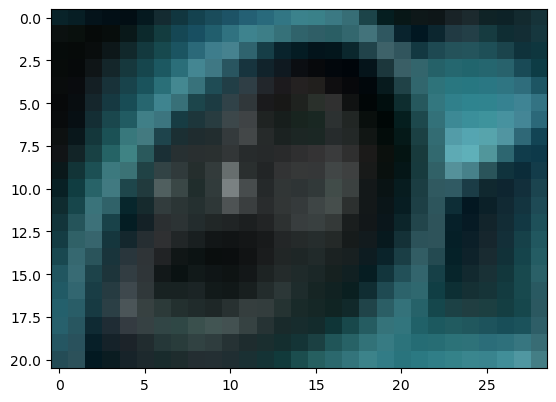

((37.27358627319336, 239.29246520996094), (47.2021369934082, 34.09678268432617), 49.63546371459961)
((379.5, 212.5), (3.0, 1.0), 90.0)
((180.0283966064453, 217.60687255859375), (34.97928237915039, 180.7379913330078), 87.32144927978516)
((298.5765075683594, 225.130615234375), (14.208795547485352, 73.43029022216797), 5.47736930847168)
((317.0362548828125, 140.80734252929688), (52.441436767578125, 124.59331512451172), 87.4266357421875)
((198.73997497558594, 123.67999267578125), (21.354625701904297, 32.38549041748047), 81.8698959350586)
((287.5, 89.0), (1.0, 2.0), 0.0)
((367.0, 86.5), (1.0, 0.0), -90.0)
((2.0, 87.0), (6.0, 4.0), 90.0)
((285.0, 80.0), (0.0, 0.0), 0.0)
((364.0, 81.5), (2.0, 5.0), 0.0)
((334.0, 78.0), (0.0, 0.0), 0.0)
((355.5, 64.5), (11.0, 23.0), 90.0)
((190.5, 54.5), (1.0, 1.0), 90.0)
((254.75001525878906, 51.74999237060547), (0.7071067094802856, 1.4142134189605713), 45.0)
((263.75, 46.249996185302734), (2.8284268379211426, 10.60660171508789), 45.0)
((383.0, 39.5), (1.0, 0.

In [101]:
findPlate = PlateFinder(minPlateArea=100, 
                            maxPlateArea=15000)
model = OCR(modelFile="model/binary_128_0.50_ver3.pb", labelFile="model/binary_128_0.50_labels_ver2.txt")

img=cv2.imread("Cars11.png")
possible_plates = findPlate.find_possible_plates(img)
if possible_plates is not None:

    for i, p in enumerate(possible_plates):
        chars_on_plate = findPlate.char_on_plate[i]
        recognized_plate, _ = model.label_image_list(
                   chars_on_plate, imageSizeOuput = 128)

        print(recognized_plate)
        cv2.imshow('plate', p)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            
            break


In [36]:
findPlate = PlateFinder(minPlateArea=100, 
                            maxPlateArea=15000)
model = OCR(modelFile="model/binary_128_0.50_ver3.pb", labelFile="model/binary_128_0.50_labels_ver2.txt")

cap = cv2.VideoCapture('test1.mp4')

while (cap.isOpened()):
    ret, img = cap.read()

    if ret == True:
        cv2.imshow('original video', img)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

        possible_plates = findPlate.find_possible_plates(img)
        if possible_plates is not None:

            for i, p in enumerate(possible_plates):
                chars_on_plate = findPlate.char_on_plate[i]
                recognized_plate, _ = model.label_image_list(
                           chars_on_plate, imageSizeOuput = 128)

                print(recognized_plate)
                cv2.imshow('plate', p)

                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()


Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
Passed pre Ratio..
In validate Ratio..
In Ratio..
In contours
In find characters
